# 0.导包、导数据

In [1]:
import xgboost as xgb
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix

from sklearn.ensemble import RandomForestClassifier  
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [7]:
# 取17-23作为测试，24作为验证
data = pd.read_pickle('data/round1_train2')
feature_train = data[data['f16'] <= 1537718400]
feature_train.drop('label',axis = 1,inplace = True)
feature_val = data[data['f16'] >= 1537718401]
feature_val.drop('label',axis = 1,inplace = True)

label_train = data[data['f16'] <= 1537718400]['label']
label_val = data[data['f16'] >= 1537718401]['label']

data = pd.read_pickle('data/round1_test2')
feature_test = data

data_index = pd.DataFrame(np.genfromtxt('data/round1_test.txt',dtype = np.str, delimiter=' ',skip_header=1))[0]

In [6]:
feature_test['f1-count-5']

0        0.0
1        3.0
2        3.0
3        3.0
4        3.0
5        3.0
6        0.0
7        0.0
8        3.0
9        3.0
10       3.0
11       3.0
12       3.0
13       0.0
14       3.0
15       3.0
16       1.0
17       3.0
18       3.0
19       3.0
20       1.0
21       3.0
22       2.0
23       1.0
24       5.0
25       3.0
26       0.0
27       1.0
28       1.0
29       3.0
        ... 
18341    0.0
18342    0.0
18343    0.0
18344    0.0
18345    0.0
18346    0.0
18347    0.0
18348    0.0
18349    0.0
18350    0.0
18351    0.0
18352    0.0
18353    0.0
18354    0.0
18355    0.0
18356    0.0
18357    0.0
18358    0.0
18359    1.0
18360    1.0
18361    0.0
18362    1.0
18363    0.0
18364    0.0
18365    0.0
18366    0.0
18367    0.0
18368    0.0
18369    0.0
18370    0.0
Name: f1-count-5, Length: 18371, dtype: float64

In [12]:
list(feature_train.columns)

['f0',
 'f1',
 'f2:2_22731265849056483',
 'f2:2_509660095530134768',
 'f2:2_1968056100269760729',
 'f2:2_2011981573061447208',
 'f2:2_2436715285093487584',
 'f2:2_2642175453151805566',
 'f2:2_3203673979138763595',
 'f2:2_4879721024980945592',
 'f2:2_5755694407684602296',
 'f2:2_5799347067982556520',
 'f2:2_7258015885215914736',
 'f2:2_8277336076276184272',
 'f2:2_8710739180200009128',
 'f2:3_-1',
 'f2:3_6233669177166538628',
 'f2:3_8868887661186419229',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11:woman',
 'f11:man',
 'f11:family',
 'f11:other',
 'f12',
 'f13:2002.0',
 'f13:2003.0',
 'f13:2004.0',
 'f13:2005.0',
 'f14',
 'f15',
 'f16',
 'f16:day',
 'f16:hour',
 'f16:minute',
 'f16:second',
 'f16:dayofweek',
 'f16:dayofyear',
 'f17',
 'f19',
 'f20',
 'f21',
 'f22',
 'f23',
 'f24',
 'f25',
 'f1-ratio-5',
 'f4-ratio-5',
 'f5-ratio-5',
 'f10-ratio-5',
 'f19-ratio-5',
 'f1-f4-ratio-5',
 'f1-f5-ratio-5',
 'f1-f10-ratio-5',
 'f1-f19-ratio-5',
 'f4-f5-ratio-5',
 'f4-f10-ratio-5',
 '

In [11]:
feature_train.drop([ 'f3-f18-jaccard',
 'f1-count-5',
 'f4-count-5',
 'f5-count-5',
 'f10-count-5',
 'f19-count-5',
 'f1-f4-count-5',
 'f1-f5-count-5',
 'f1-f19-count-5',
 'f4-f5-count-5',
 'f4-f19-count-5',
 'f5-f10-count-5',
 'f5-f19-count-5',
 'f1-browse-count-5',
 'f4-browse-count-5',
 'f5-browse-count-5',
 'f10-browse-count-5',
 'f19-browse-count-5',
 'f1-f4-browse-count-5',
 'f1-f5-browse-count-5',
 'f1-f10-browse-count-5',
 'f1-f19-browse-count-5',
 'f4-f5-browse-count-5',
 'f4-f10-browse-count-5',
 'f4-f19-browse-count-5',
 'f5-f10-browse-count-5',
 'f5-f19-browse-count-5',
 'f10-f19-browse-count-5',
],axis = True,inplace = True)
# feature_train.drop(['f5-f19-browse-count-5'],axis = True,inplace = True)

In [117]:
feature_test.columns

Index(['f0', 'f1', 'f2:2_22731265849056483', 'f2:2_509660095530134768',
       'f2:2_1968056100269760729', 'f2:2_2011981573061447208',
       'f2:2_2436715285093487584', 'f2:2_2642175453151805566',
       'f2:2_3203673979138763595', 'f2:2_4879721024980945592',
       'f2:2_5755694407684602296', 'f2:2_5799347067982556520',
       'f2:2_7258015885215914736', 'f2:2_8277336076276184272',
       'f2:2_8710739180200009128', 'f2:3_-1', 'f2:3_6233669177166538628',
       'f2:3_8868887661186419229', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11:woman', 'f11:man', 'f11:family', 'f11:other', 'f12', 'f13:2002.0',
       'f13:2003.0', 'f13:2004.0', 'f13:2005.0', 'f14', 'f15', 'f16',
       'f16:day', 'f16:hour', 'f16:minute', 'f16:second', 'f16:dayofweek',
       'f16:dayofyear', 'f17', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25',
       'f1-ratio-5', 'f4-ratio-5', 'f5-ratio-5', 'f10-ratio-5', 'f19-ratio-5',
       'f1-f4-ratio-5', 'f1-f5-ratio-5', 'f1-f10-ratio-5', 'f1-f19-ratio-5',
 

In [135]:
# 取18-23作为测试，24作为验证
data = pd.read_pickle('data/round1_train2')
feature_train = data[(data['f16'] <= 1537718400) & (data['f16'] > 1537200000)]
feature_train.drop('label',axis = 1,inplace = True)
feature_val = data[data['f16'] > 1537718400]
feature_val.drop('label',axis = 1,inplace = True)

label_train = data[(data['f16'] <= 1537718400) & (data['f16'] > 1537200000)]['label']
label_val = data[data['f16'] > 1537718400]['label']

data = pd.read_pickle('data/round1_test2')
feature_test = data

data_index = pd.DataFrame(np.genfromtxt('data/round1_test.txt',dtype = np.str, delimiter=' ',skip_header=1))[0]

In [39]:
# 取17-22作为测试，23作为验证
data = pd.read_pickle('data/round1_train2')
feature_train = data[data['f16'] <= 1537632000]
feature_train.drop('label',axis = 1,inplace = True)
feature_val = data[(data['f16'] > 1537632000) & (data['f16'] <= 1537718400)]
feature_val.drop('label',axis = 1,inplace = True)

label_train = data[data['f16'] <= 1537632000]['label']
label_val = data[(data['f16'] > 1537632000) & (data['f16'] <= 1537718400)]['label']

data = pd.read_pickle('data/round1_test2')
feature_test = data

data_index = pd.DataFrame(np.genfromtxt('data/round1_test.txt',dtype = np.str, delimiter=' ',skip_header=1))[0]

In [143]:
# 取18-22作为测试，23作为验证
data = pd.read_pickle('data/round1_train2')
feature_train = data[(data['f16'] <= 1537632000) & (data['f16'] > 1537200000)]
feature_train.drop('label',axis = 1,inplace = True)
feature_val = data[(data['f16'] > 1537632000) & (data['f16'] <= 1537718400)]
feature_val.drop('label',axis = 1,inplace = True)

label_train = data[(data['f16'] <= 1537632000) & (data['f16'] > 1537200000)]['label']
label_val = data[(data['f16'] > 1537632000) & (data['f16'] <= 1537718400)]['label']

data = pd.read_pickle('data/round1_test2')
feature_test = data

data_index = pd.DataFrame(np.genfromtxt('data/round1_test.txt',dtype = np.str, delimiter=' ',skip_header=1))[0]

## 1.训练xgboost
这里要重点讲一下 Xgboost 的调参。通常认为对它性能影响较大的参数有：

- eta：每次迭代完成后更新权重时的步长。越小训练越慢。
- num_round：总共迭代的次数。
- subsample：训练每棵树时用来训练的数据占全部的比例。用于防止 Overfitting。
- colsample_bytree：训练每棵树时用来训练的特征的比例，类似 RandomForestClassifier 的 max_features。
- max_depth：每棵树的最大深度限制。与 Random Forest 不同，Gradient Boosting 如果不对深度加以限制，最终是会 Overfit 的。
- early_stopping_rounds：用于控制在 Out Of Sample 的验证集上连续多少个迭代的分数都没有提高后就提前终止训练。用于防止 Overfitting。

一般的调参步骤是：

- 将训练数据的一部分划出来作为验证集。
- 先将 eta 设得比较高（比如 0.1），num_round 设为 300 ~ 500。
- 用 Grid Search 对其他参数进行搜索
- 逐步将 eta 降低，找到最佳值。
- 以验证集为 watchlist，用找到的最佳参数组合重新在训练集上训练。注意观察算法的输出，看每次迭代后在验证集上分数的变化情况，从而得到最佳的 early_stopping_rounds。

In [53]:
feature_train.fillna(-1,inplace = True)
feature_val.fillna(-1,inplace = True)
feature_test.fillna(-1,inplace = True)

In [13]:
train = xgb.DMatrix(feature_train,label = label_train)
val = xgb.DMatrix(feature_val,label = label_val)
test = xgb.DMatrix(feature_test)

In [123]:
feature_val.shape,feature_train.shape,feature_test.shape

((57334, 82), (419969, 82), (18371, 82))

In [14]:
# coding=utf-8


param = {
    # 1.General Parameters
    'booster': 'gbtree', # 提升计算的模型，可以是：gbtree, gblinear or dart
    'silent': 0,  # 0为打印信息，1为缄默
    # 'nthread': 4, # XGBoost运行时的线程数
    # 'num_pbuffer': # 预测缓冲区的大小，通常设置为训练实例的数量。缓冲区用于保存最后一次提升步骤的预测结果。
    # 'num_feature': # 特征值数量
    
    # 2.Booster Parameters
    'eta': 0.05,  # 学习率，默认0.3，取值范围为：[0,1]，典型值为0.01-0.2，越小越保守
    'gamma': 0.1,  # 节点分裂所需的最小损失函数下降值，和损失函数息息相关。默认0，典型值0.1、0.2，越大越保守，
    'max_depth': 5,  # 树的最大深度，默认6，典型值为3-10，越大越易过拟合。
    'min_child_weight':1, # 这个参数非常影响结果，最小叶子节点样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。默认1，越大算法越易欠拟合
    'max_delta_step ':0, # 限制每棵树权重改变的最大步长。越大越保守。通常，这个参数不需要设置。但是当各类别的样本十分不平衡时，它对逻辑回归是很有帮助的。
    'subsample':0.8, # 用于训练模型的子样本占整个样本集合的比例，行采样，典型值0.5-1，越小越保守。
    'colsample_bytree ': 0.8,  # 在建立树时对特征采样的比例，列采样。典型值0.5-1

    'lambda':10, # 权重的L2正则化项，默认是1
    'alpha':1,# 权重的L1正则化项，默认是1
    'lambda_bias': 0,  # 在偏置上的L2正则。缺省值为0（在L1上没有偏置项的正则，因为L1时偏置不重要）
    # 'scale_pos_weight':0.5, # 各类样本十分不平衡时，把这个参数设置为一个正数，可以使算法更快收敛。默认是1

    # 3.Task Parameters
    # 'tree_method': 'approx',
    'objective': 'binary:logistic',  # 使用的模型，分类的数目
    'eval_metric':'logloss', # 校验数据所需要的评价指标，不同的目标函数将会有缺省的评价指标
    'base_score':0.5, # 对于所有样本预测为正样本的全局偏置（初始分数）。如果迭代次数够多，改变这个参数对结果不会有影响。
    'seed':0 # 随机数的种子
}
num_boost_round = 1000  # 迭代的次数，弱分类器的数量

watchlist = [(train, 'train'),(val, 'val')]  # 看板，每次迭代都可以在控制台打印出训练集与测试集的损失

In [15]:
# obj、feval、early_stopping_rounds、evals_result、verbose_eval、xgb_model

bst = xgb.train(param, train, num_boost_round, evals=watchlist, obj=None, feval=None, maximize=False,
      early_stopping_rounds=50, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None,learning_rates=None)
bst.save_model('data/model_xgboost')

[0]	train-logloss:0.648047	val-logloss:0.647781
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.607253	val-logloss:0.606737
[2]	train-logloss:0.570176	val-logloss:0.569446
[3]	train-logloss:0.536354	val-logloss:0.535397
[4]	train-logloss:0.5054	val-logloss:0.50423
[5]	train-logloss:0.476977	val-logloss:0.475625
[6]	train-logloss:0.450829	val-logloss:0.449279
[7]	train-logloss:0.42672	val-logloss:0.424979
[8]	train-logloss:0.404432	val-logloss:0.402524
[9]	train-logloss:0.38379	val-logloss:0.381682
[10]	train-logloss:0.364664	val-logloss:0.362374
[11]	train-logloss:0.346903	val-logloss:0.344447
[12]	train-logloss:0.33038	val-logloss:0.327788
[13]	train-logloss:0.315002	val-logloss:0.312244
[14]	train-logloss:0.300671	val-logloss:0.297771
[15]	train-logloss:0.287312	val-logloss:0.284285
[16]	train-logloss:0.274828	val-logloss:0.271655
[17]	train-logloss:0.263163	val-logl

[164]	train-logloss:0.08735	val-logloss:0.081522
[165]	train-logloss:0.087324	val-logloss:0.081517
[166]	train-logloss:0.087305	val-logloss:0.081509
[167]	train-logloss:0.087284	val-logloss:0.081506
[168]	train-logloss:0.087269	val-logloss:0.081502
[169]	train-logloss:0.087251	val-logloss:0.081501
[170]	train-logloss:0.087225	val-logloss:0.081507
[171]	train-logloss:0.0872	val-logloss:0.081501
[172]	train-logloss:0.087176	val-logloss:0.081503
[173]	train-logloss:0.08716	val-logloss:0.081494
[174]	train-logloss:0.087136	val-logloss:0.081493
[175]	train-logloss:0.087122	val-logloss:0.081501
[176]	train-logloss:0.0871	val-logloss:0.081509
[177]	train-logloss:0.087084	val-logloss:0.081501
[178]	train-logloss:0.087065	val-logloss:0.081496
[179]	train-logloss:0.087041	val-logloss:0.081494
[180]	train-logloss:0.087024	val-logloss:0.08149
[181]	train-logloss:0.087	val-logloss:0.081489
[182]	train-logloss:0.086977	val-logloss:0.08149
[183]	train-logloss:0.086961	val-logloss:0.081494
[184]	train

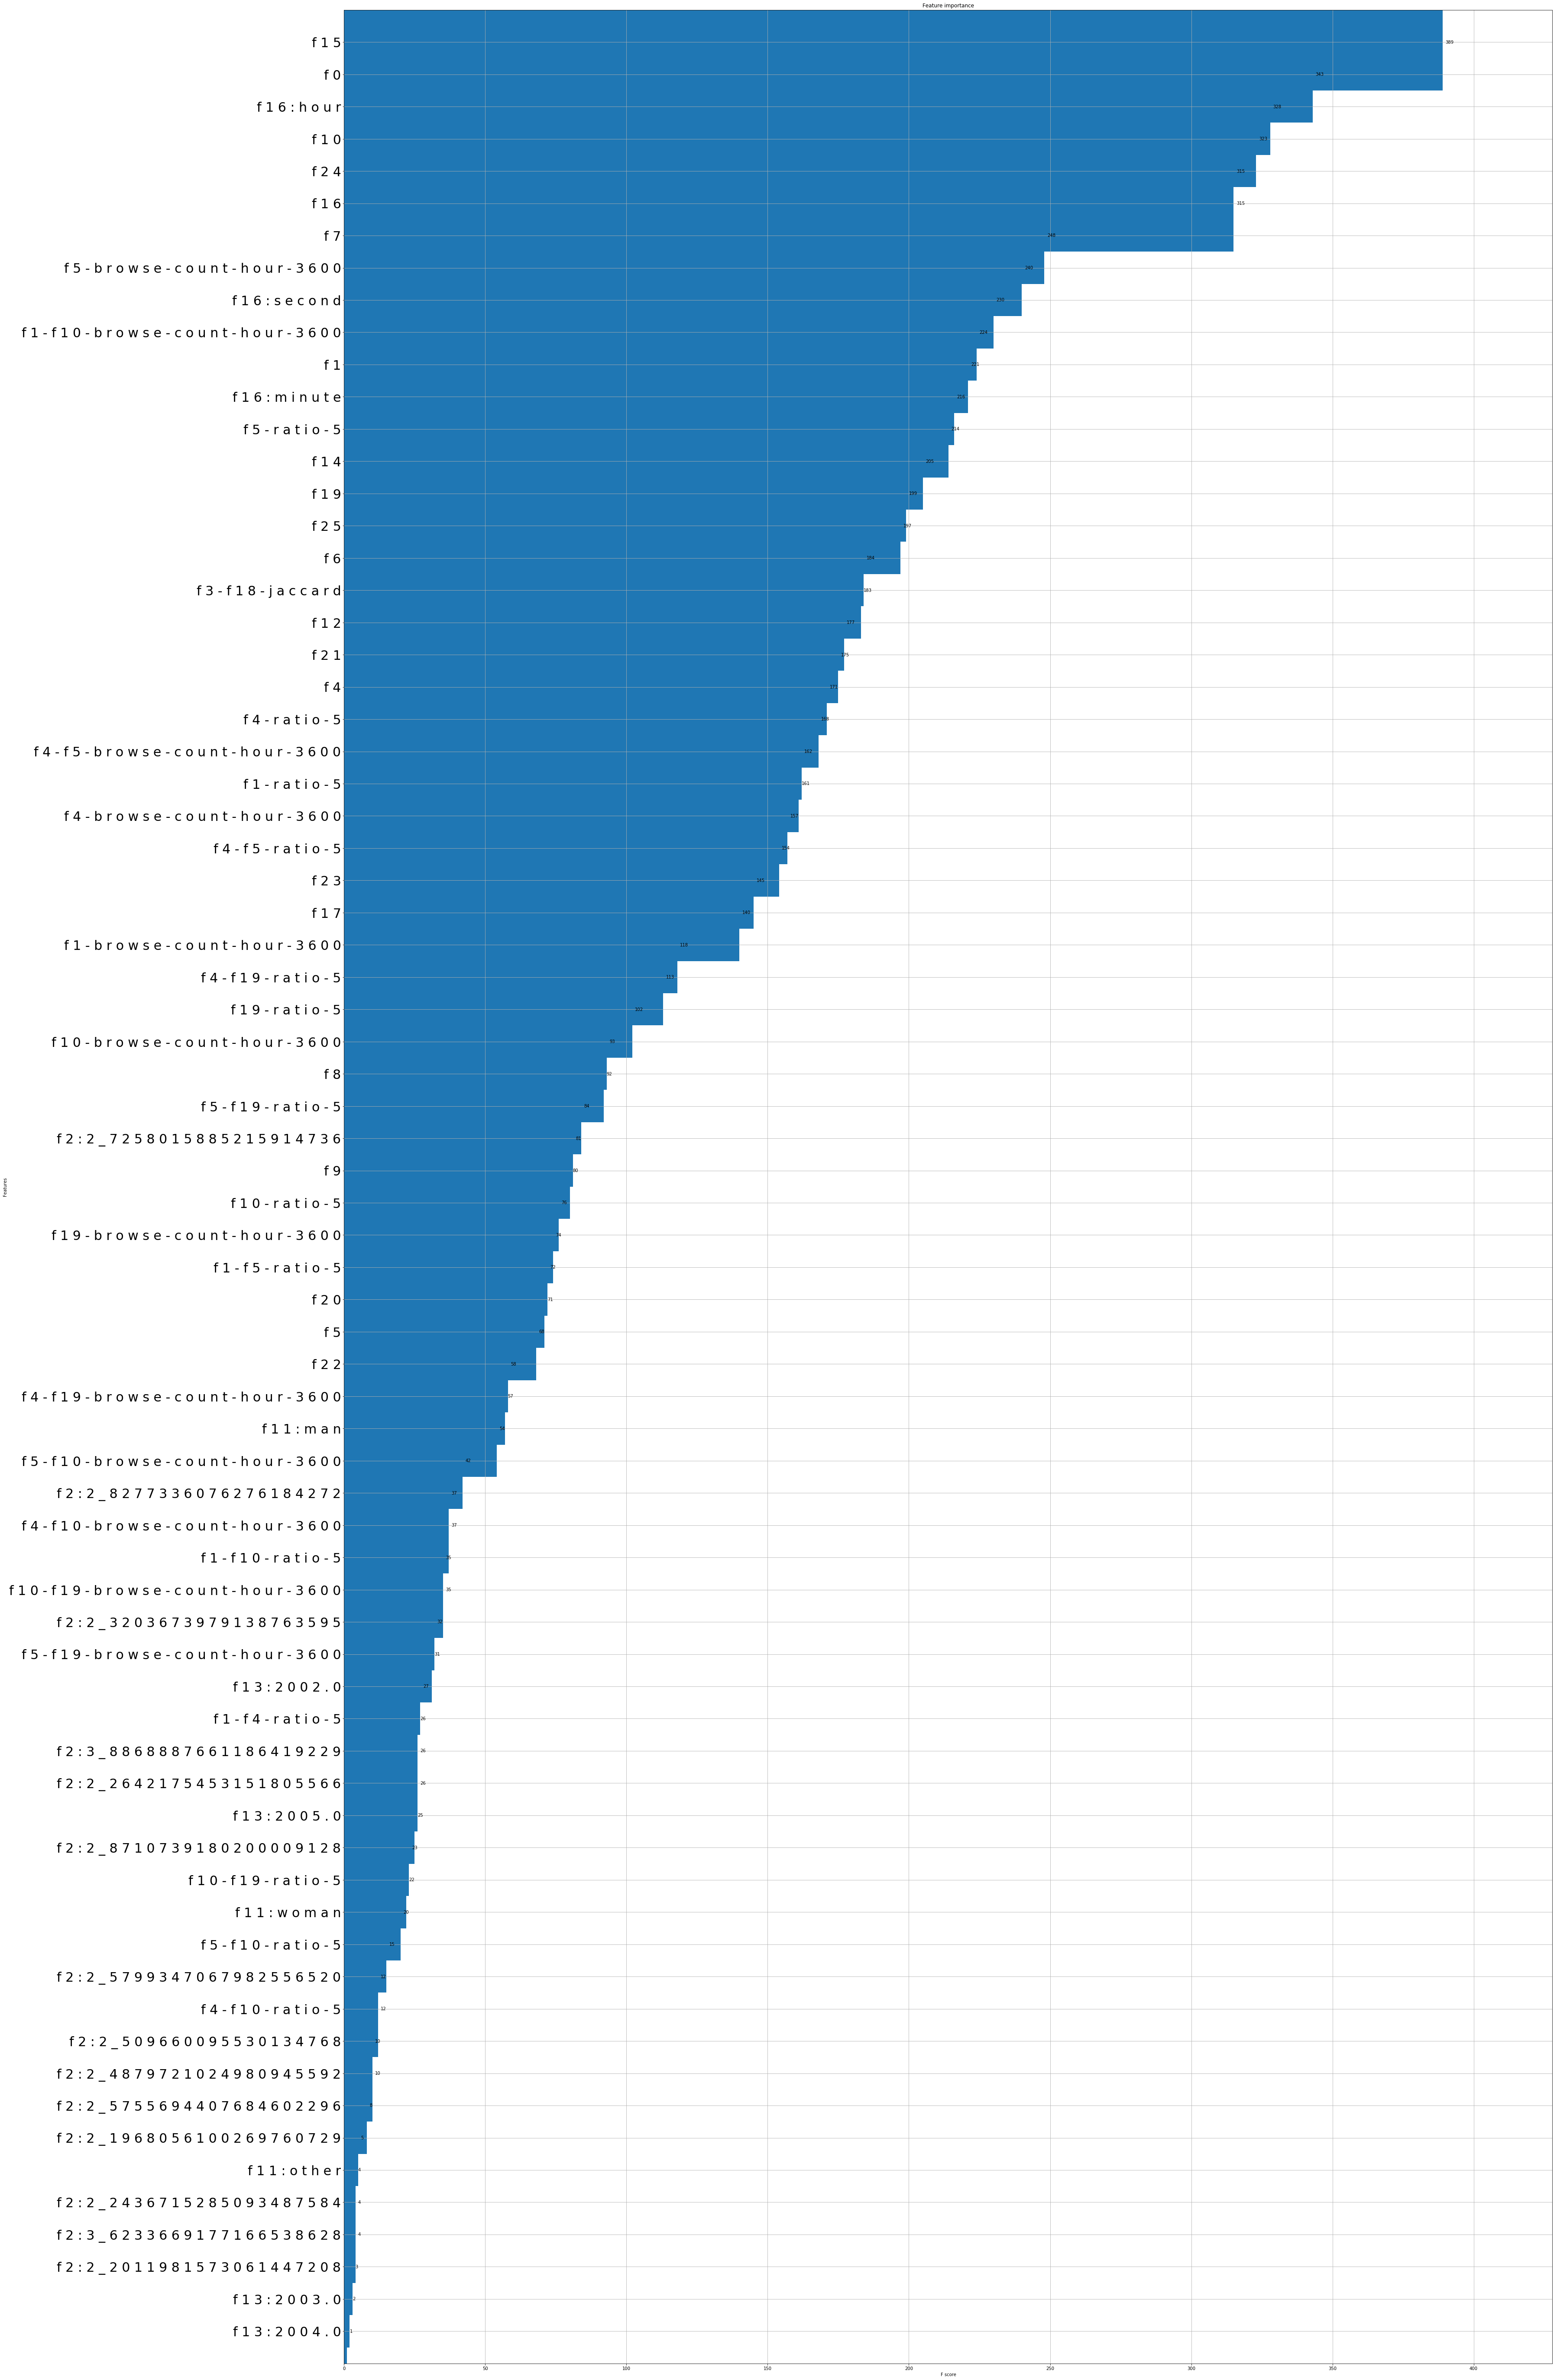

In [126]:
ax = plt.subplot(111)
plt.yticks(fontsize=30)
ax = xgb.plot_importance(bst,ax,height  = 3)
fig = ax.figure
fig.set_size_inches(50, 100)

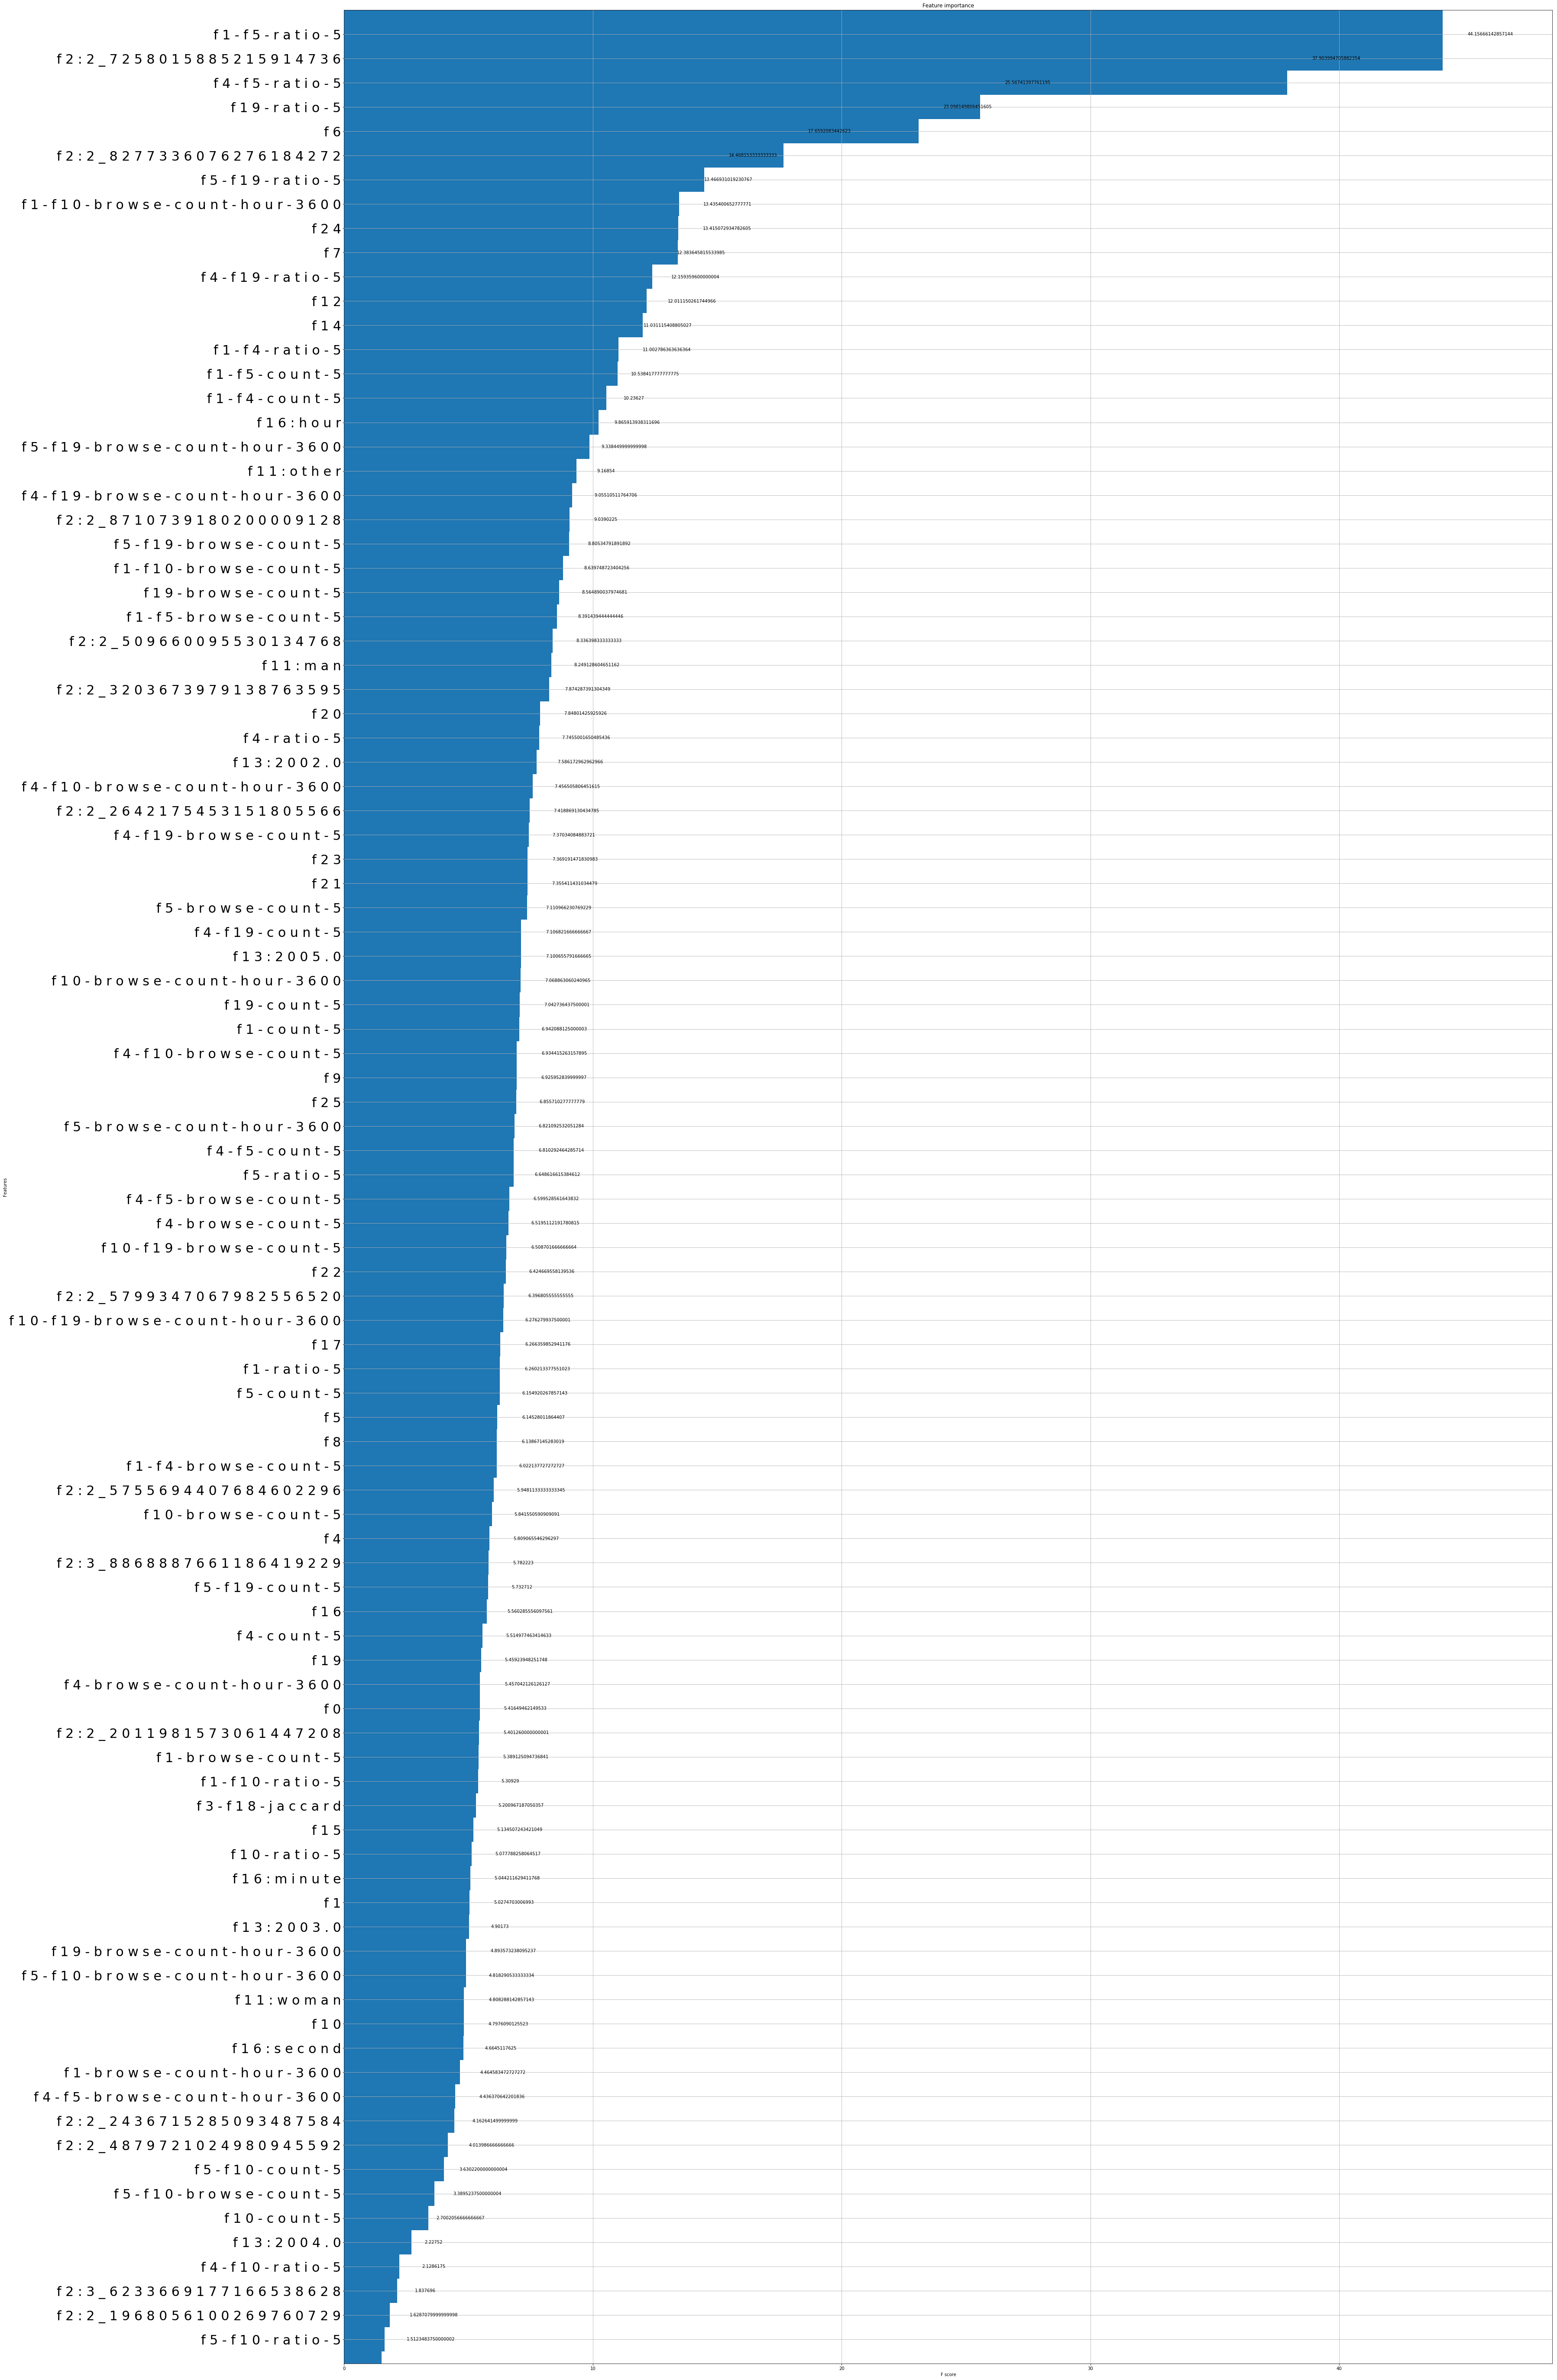

In [71]:
ax = plt.subplot(111)
plt.yticks(fontsize=30)
ax = xgb.plot_importance(bst,ax,importance_type = 'gain',height  = 3)
fig = ax.figure
fig.set_size_inches(50, 100)

In [16]:
# 预测
label_test_xgb = bst.predict(test)
# 4.保存
np.savetxt('data/round1_result_xgb.txt', np.c_[data_index, label_test_xgb], delimiter=',', header='instance_id predicted_score',comments='', fmt='%s %f')

In [27]:
from sklearn.model_selection import GroupKFold

data = pd.read_pickle('data/round1_train2')

gkf = GroupKFold(n_splits=8)
    
data = pd.read_pickle('data/round1_train2')
data = xgb.DMatrix(data.drop('label',axis = 1),label = data['label'])

bst = xgb.cv(param, data, num_boost_round, folds=gkf, early_stopping_rounds=50,verbose_eval = True)

77371
71094
70322
68559
68082
62778
52446
6651


## 2.训练SVM

In [45]:
from sklearn import svm,datasets
from sklearn.metrics import log_loss

#调用SVC()
# 参数见：http://blog.csdn.net/xiaodongxiexie/article/details/70667101
clf = svm.SVC(
            C=0.001, 
            kernel='rbf', 
            degree=3, 
            gamma='auto', 
            coef0=0.0, 
            probability=False, 
            shrinking=True, 
            tol=0.001, 
            cache_size=200, 
            class_weight='balanced', 
            verbose=True, 
            max_iter=1000, 
            decision_function_shape='ovr', 
            random_state=None
)
#载入鸢尾花数据集
iris = datasets.load_iris()

#fit()训练
clf.fit(feature_train,label_train)

#predict()预测
label_val_svm = clf.predict(feature_val)
print(log_loss(label_val,label_val_svm))

[LibSVM]

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


33.957631066


## 3.训练逻辑回归

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss


feature_train_now = StandardScaler().fit_transform(feature_train)


clf_l1_LR= LogisticRegression(
#    tol = 0.0001,C = 0.00005, penalty = 'l1',max_iter = 500,class_weight = 'balanced',verbose = 2
) 
clf_l1_LR.fit(feature_train_now,label_train)
label_val_lr = clf_l1_LR.predict(feature_val)  
print(log_loss(label_val,label_val_lr))


clf_l2_LR= LogisticRegression(
#    tol = 0.0001,C = 0.0001, penalty = 'l2',max_iter = 500,class_weight = 'balanced',verbose = 2
) 
clf_l2_LR.fit(feature_train_now,label_train)
label_val_lr = clf_l2_LR.predict(feature_val)
print(log_loss(label_val,label_val_lr))

1.1711058309
1.1711058309


# 4.AdaBoost

In [55]:
clf = AdaBoostClassifier() #迭代100次  
clf.fit(feature_train,label_train)
label_val_lr = clf.predict(feature_val)  
print(log_loss(label_val,label_val_lr))

0.581931454242


# 5.训练Random Forest

In [56]:
clf = RandomForestClassifier()
clf.fit(feature_train , label_train)
label_val_rf = clf.predict(feature_val)    
print(log_loss(label_val,label_val_rf))

0.584341164082


# 6.lightbgm

In [58]:
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='binary',

                        num_leaves=64,

                        learning_rate=0.01,

                        n_estimators=2000)

gbm.fit(feature_train, label_train,

        eval_set=[(feature_val, label_val)],

        eval_metric='binary_logloss',

        early_stopping_rounds=300)

LightGBMError: b'Check failed: num_data > 0 at /home/travis/build/Microsoft/LightGBM/python-package/compile/src/io/dataset.cpp, line 27 .\n'

In [63]:
label_val_bgm = gbm.predict(feature_val, num_iteration=gbm.best_iteration_)

label_test = gbm.predict(feature_test, num_iteration=gbm.best_iteration_)

print(log_loss(label_val,label_val_bgm))

0.0821183476381


In [64]:
np.savetxt('data/round1_result_lgb.txt', np.c_[data_index, label_test], delimiter=',', header='instance_id predicted_score',comments='', fmt='%s %f')

# 7.GBDT

In [61]:
from sklearn.ensemble import GradientBoostingClassifier    
model = GradientBoostingClassifier()    
model.fit(feature_train, label_train)    
label_val_gbdt = clf.predict(feature_val)  
print(log_loss(label_val,label_val_gbdt))

0.584341164082


# 8.FM/FFM


In [62]:
label_train[label_train < 0.5] = -1.0

In [63]:
feature_train = csc_matrix(feature_train)

In [64]:
feature_val = csc_matrix(feature_val)

In [65]:
from fastFM import sgd,mcmc
fm = sgd.FMClassification(
#     n_iter=1000, init_stdev=0.1, l2_reg_w=0,l2_reg_V=0, rank=2, step_size=0.1
)
fm.fit(feature_train, label_train)
label_val_fm = fm.predict(feature_val)

# fm = mcmc.FMClassification(n_iter=1000, rank=2, init_stdev=0.1)
# y_pred = fm.fit_predict(X_train, y_train, X_test)
# label_val_fm = fm.fit_predict_proba(X_train, y_train, X_test)

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/fastFM/base.py:123: RuntimeWarning: invalid value encountered in greater
  y_pred[y_proba > .5] = self.classes_[1]


In [66]:
pd.Series(label_val_fm).value_counts()

-1.0    57334
dtype: int64

# 9.集成
要求：
- Base Model 之间的相关性要尽可能的小
- Base Model 之间的性能表现不能差距太大

## 9.1Bagging
- 使用训练数据的不同随机子集来训练每个 Base Model，最后进行每个 Base Model 权重相同的 Vote。

## 9.2Boosting
- 迭代地训练 Base Model，每次根据上一个迭代中预测错误的情况修改训练样本的权重。

## 9.3Blending
- 用不相交的数据训练不同的 Base Model，将它们的输出取（加权）平均。实现简单，但对训练数据利用少了。

## 9.4Stacking
- 我用了两层的模型融合，Level 1使用了：XGBoost、LightGBM、RandomForest、ExtraTrees、DecisionTree、AdaBoost，一共6个模型，Level 2使用了LinearRegression来拟合第一层的结果。
- http://blog.csdn.net/a358463121/article/details/53054686